<a href="https://colab.research.google.com/github/9terry-student/pytorch/blob/main/Tokenization%2BEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# 라이브러리
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# 문장->토큰화->토큰ID
sentence="I went to the hospital"
tokens=sentence.lower().split()
print("tokens:",tokens)

vocab={w:i for i,w in enumerate(tokens)}
print("vocab:",vocab)

token_ids=torch.tensor([[vocab[w] for w in tokens]])    # (B=1,S=5)
print("token_ids:",token_ids)

# Embedding
B,S=token_ids.shape
D=8   # embedding dimension

embedding=nn.Embedding(len(vocab),D)
x=embedding(token_ids)

print("embedding output shape:",x.shape)    # (1,5,8)

tokens: ['i', 'went', 'to', 'the', 'hospital']
vocab: {'i': 0, 'went': 1, 'to': 2, 'the': 3, 'hospital': 4}
token_ids: tensor([[0, 1, 2, 3, 4]])
embedding output shape: torch.Size([1, 5, 8])


In [35]:
# Multi-Head Attention
class MultiHeadAttention(nn.Module):
  def __init__(self,embed_dim,num_heads):
    super().__init__()
    assert embed_dim%num_heads==0, "D는 head 수로 나누어 떨어져야 함"
    self.num_heads=num_heads
    self.head_dim=embed_dim//num_heads

    # Q,K,V를 전체 D에서 한 번에 만들기
    self.q=nn.Linear(embed_dim,embed_dim)
    self.k=nn.Linear(embed_dim,embed_dim)
    self.v=nn.Linear(embed_dim,embed_dim)

    self.out=nn.Linear(embed_dim,embed_dim)

  def forward(self,x):
    B,S,D=x.shape

    # Q,K,V shape: (B,S,D)
    Q=self.q(x)
    K=self.k(x)
    V=self.v(x)

    # Multi-Head로 나누기: (B,head,S,head_dim)
    Q=Q.view(B,S,self.num_heads,self.head_dim).transpose(1,2)
    K=K.view(B,S,self.num_heads,self.head_dim).transpose(1,2)
    V=V.view(B,S,self.num_heads,self.head_dim).transpose(1,2)

    # Attention 계산
    scores=Q@K.transpose(-2,-1)/(self.head_dim**0.5)
    weights=F.softmax(scores,dim=-1)
    out=weights@V   # (B,head,S,head_dim)

    # 다시 합치기
    out=out.transpose(1,2).contiguous().view(B,S,D)
    out=self.out(out)
    return out,weights

In [36]:
# Mini Encoder
class MiniEncoder(nn.Module):
  def __init__(self,embed_dim,num_heads):
    super().__init__()
    self.mha=MultiHeadAttention(embed_dim,num_heads)
    self.norm1=nn.LayerNorm(embed_dim)
    self.norm2=nn.LayerNorm(embed_dim)

    self.ff=nn.Sequential(
        nn.Linear(embed_dim,4*embed_dim),
        nn.ReLU(),
        nn.Linear(4*embed_dim,embed_dim)
    )
  def forward(self,x):
    # Multi-Head+Residual+LayerNorm
    attn_out,weights=self.mha(x)
    x=self.norm1(x+attn_out)

    # FeedForward+Residual+LayerNorm
    ff_out=self.ff(x)
    x=self.norm2(x+ff_out)

    return x,weights

In [37]:
# Forward 실행
encoder=MiniEncoder(D,num_heads=2)
output,attn_weights=encoder(x)

print("encoder output shape:",output.shape)

encoder output shape: torch.Size([1, 5, 8])


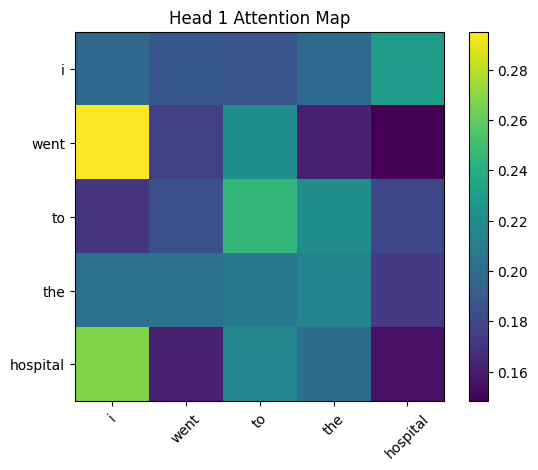

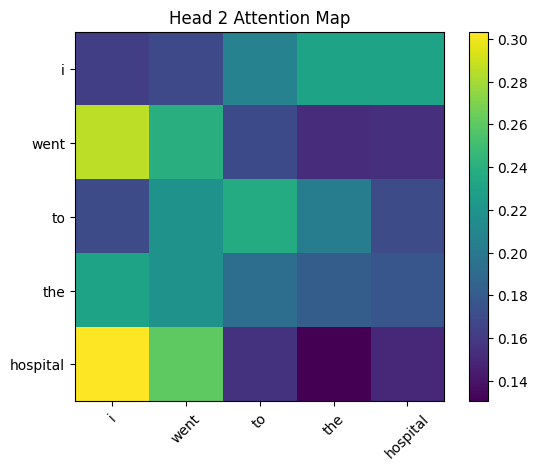

In [38]:
# 시각화
for h in range(attn_weights.shape[1]):
  plt.figure()
  plt.imshow(attn_weights[0,h].detach().numpy())
  plt.xticks(range(S),tokens,rotation=45)
  plt.yticks(range(S),tokens)
  plt.colorbar()
  plt.title(f"Head {h+1} Attention Map")
  plt.show()